In [15]:
# Read simulator images from udacity training set
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

augment_cnt = 2000
sample_cnt = int(os.popen("wc -l data/driving_log.csv | awk '{print $1}'").read().strip())
lines = np.arange(sample_cnt-1+augment_cnt)
np.random.shuffle(lines)

#80/20 split for training and validation sets
train_split=int(len(lines)*0.8)
train_idx=lines[0:train_split]
valid_idx=lines[train_split:len(lines)]


In [37]:
def process_img(image, corr):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #img = img[..., np.newaxis]
    #img = img[50:300,:]
    if corr == -1 :
        img = np.fliplr(img)
    return img

def get_data(sample_idx, batch_size):
    while 1:
        df = pd.read_csv('data/driving_log.csv')
        idx=0
        images=[]
        measurements = []
        for x in range(batch_size):
            if idx >= sample_cnt:   #flip an image
                idx1 = idx % sample_cnt
                corr = -1
            else :
                idx1 = idx
                corr = 1
                
            cimg = "data/" + df["center"][idx1].strip()
            ang = df["steering"][idx1]
            limg = "data/" + df["left"][idx1].strip()
            rimg = "data/" + df["right"][idx1].strip()
            
            img = cv2.imread(cimg)
            #print("Image is ", cimg, img)
            images.append(process_img(img, corr))
            measurements.append(ang*corr)
            
            img = cv2.imread(limg)
            #print("Image is ", limg, img)
            images.append(process_img(img, corr))
            measurements.append((ang+0.2)*corr)
            
            img = cv2.imread(rimg)
            #print("Image is ", rimg, img)
            images.append(process_img(img, corr))
            measurements.append((ang-0.2)*corr)
            
            idx+=1
        yield (np.array(images), np.array(measurements))
        

In [ ]:
# Model based on https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# Using keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Dense, Lambda, Cropping2D, Activation, Flatten

model = Sequential()

# pre process as described in lecture
# 1. Normalize input data
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3))) 

# 2. Crop 60 pixels off the top and 10 pixels off the bottom of images
model.add(Cropping2D(cropping=((60,10),(0,0)))) 

# Nvidia model layers
model.add(Conv2D(filters=24, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters=36, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=48, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# train model
model.fit_generator(get_data(train_idx, 128), 
                    steps_per_epoch=len(train_idx) / 128,
                    validation_data=get_data(valid_idx, 128),
                    validation_steps=len(valid_idx) / 128,
                    epochs=5)
#model.fit_generator(, steps_per_epoch=80, epochs=5)
#model.fit(X_train, y_train, validation_split=0.25, shuffle=True, epochs=7)
model.save('model.h5')

Epoch 1/5
54/62 [========================>.....] - ETA: 71s - loss: 0.0081 - acc: 0.2344 

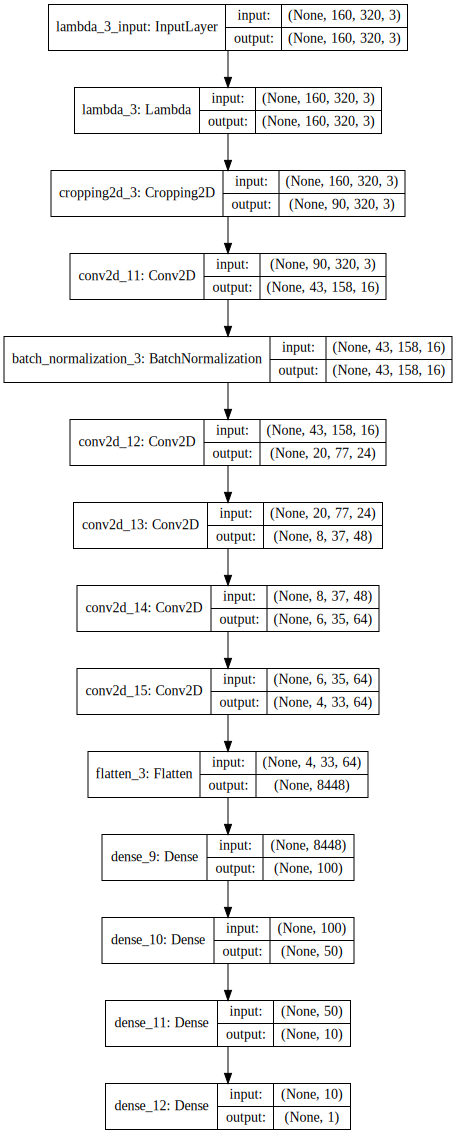

In [21]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


#### Files Submitted & Code Quality

*1. Submission includes all required files and can be used to run the simulator in autonomous mode*

My project includes the following files:
* Model.ipynb containing the script to create and train the model
* drive.py for driving the car in autonomous mode; Changed the speed to 15 from the default udacity code
* model.h5 containing a trained convolution neural network
* writeup_report.md or writeup_report.pdf summarizing the results

*2. Submission includes functional code*
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing
```sh
python drive.py model.h5
```

*3. Submission code is usable and readable*
The Model.ipynb file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

#### Model Architecture and Training Strategy

*1. An appropriate model architecture has been employed*

My model is a slightly modified version of the Nvidia architecture described in class (http://images.nvidia.com/content/tegra/automotive/images/ 2016/solutions/pdf/end-to-end-dl-using-px.pdf).
Figure 4 and "section 4 Network Architecture" provided all the details for the base implementation. I expermiented with different max pooloing   and dropout  layers. Finally settled on a single additional batch normalization layer after the first Convolution layer.

I also used the cropping layer + normalization layer as described in the lectures. This is done before the convolution layers.

*2. Attempts to reduce overfitting in the model*

Experimented with dropout layers. The best accuracy was with the additional batch norm layer.

The model was trained and validated on different data sets to ensure that the model was not overfitting. The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.

*3. Model parameter tuning*

The model used an adam optimizer, so the learning rate was not tuned manually.

*4. Appropriate training data*

I eventually used the images provided. Center+left+right camera images. I flipped some randomly picked images as can be seen in the graph after  cnt 8000. I set the validation split to be 25%. I also used some images from training the model using the simulator. I have appended the images I have generated to the end of the driving_log.csv. The simulator does not have a good response on my laptop and hence you can see the much bigger steering angles in the plot for x_val > 8000. 

I converted the images to RGB as a preprocessing step. I have also tried to use cv2 on a second set of images to visualize the effects. I was not sure how to get intermediate outputs from keras.

#### Model Architecture and Training Strategy

*1. Solution Design Approach*
1. Try to collect training images using simulator
2. Used udacity training data
3. Crop and normalize layers using keras
4. Nvidia deep learning network model
5. Experiment with different batch norm/max pooling/drop out layers. Captured model.h5 files and moitored validation accuracy.
6. Tweaked the steering angle in the original training data and tried the network.
7. Picked the best model that runs on the simulator in auto mode

*2. Final Model Architecture*
Described above

*3. Creation of the Training Set & Training Process*
Collecting my own images did not work very well. I have used a few of them for training the network.

I tried the use the fit generator aproach after reading this really amazing quora answer.
https://www.quora.com/Intuitively-how-does-mini-batch-size-affect-the-performance-of-stochastic-gradient-descent
However the smaller batch size, greater number of epochs was taking too long to run and did not yeild a higer accuracy in reasonable time. 
Thankfully while using the entire X_train set, I did not run into memory issues and this approach seemed to work.